# Scouting With Machine Learning

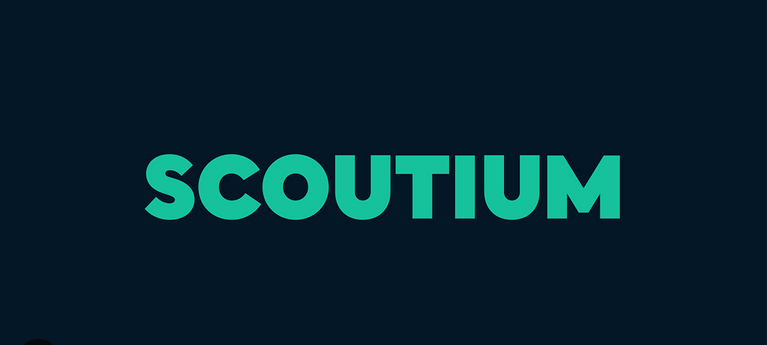

Business Problem: Based on the ratings given to the player's skills by scouts, predict which class (average, highlighted) the players belong to.

The data set consists of information from Scoutium, which includes the skills and scores of the football players evaluated by the scouts, according to the skills of the football players observed in the matches.

**Import Libraries**

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

___

### Step1: Read csv files

In [2]:
attributes_df = pd.read_csv('scoutium_attributes.csv', sep=';')

In [3]:
attributes_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [4]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 670.8 KB


In [5]:
potential_labels_df = pd.read_csv('scoutium_potential_labels.csv', sep=';')

In [6]:
potential_labels_df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [7]:
potential_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   task_response_id  322 non-null    int64 
 1   match_id          322 non-null    int64 
 2   evaluator_id      322 non-null    int64 
 3   player_id         322 non-null    int64 
 4   potential_label   322 non-null    object
dtypes: int64(4), object(1)
memory usage: 12.7+ KB


### Step 2: Merge two dataframe 

In [8]:
df = pd.merge(attributes_df, potential_labels_df, on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'])

In [9]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 838.3+ KB


In [11]:
df.isnull().sum()

task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
potential_label     0
dtype: int64

In [12]:
df.nunique()

task_response_id     29
match_id             17
evaluator_id         10
player_id           277
position_id          10
analysis_id         323
attribute_id         39
attribute_value      10
potential_label       3
dtype: int64

In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio': round(100*(dataframe[col_name].value_counts()) / len(dataframe), 2)}))
    
    if plot:
        plt.figure(figsize=(5, 3))
        sns.countplot(x=col_name, data=dataframe)
        plt.show()
        
    print('######################################################################\n')

               potential_label  Ratio
average                   8497  79.19
highlighted               2097  19.54
below_average              136   1.27


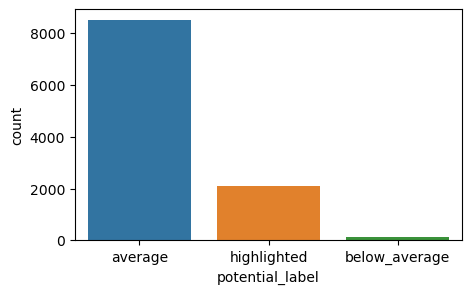

######################################################################



In [14]:
cat_summary(df, 'potential_label', plot=True)

       attribute_value  Ratio
67.0              3447  32.12
56.0              2037  18.98
45.0              1864  17.37
34.0              1377  12.83
78.0              1261  11.75
23.0               667   6.22
12.0                41   0.38
89.0                32   0.30
100.0                3   0.03
1.0                  1   0.01


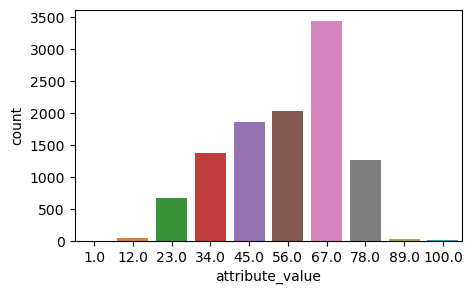

######################################################################



In [15]:
cat_summary(df, 'attribute_value', plot=True)

### Step 3: Remove the goalkeeper (1) in position_id

In [16]:
df[df['position_id'] == 1]

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
238,4915,62935,177676,1369060,1,12818481,4322,45.0,average
239,4915,62935,177676,1369060,1,12818481,4323,34.0,average
240,4915,62935,177676,1369060,1,12818481,4324,45.0,average
241,4915,62935,177676,1369060,1,12818481,4325,56.0,average
242,4915,62935,177676,1369060,1,12818481,4326,56.0,average
...,...,...,...,...,...,...,...,...,...
10691,5642,63032,151191,1605952,1,12825764,4355,67.0,average
10692,5642,63032,151191,1605952,1,12825764,4357,67.0,average
10693,5642,63032,151191,1605952,1,12825764,4409,67.0,average
10694,5642,63032,151191,1605952,1,12825764,4423,67.0,average


In [17]:
df.drop(df[df['position_id'] == 1].index, inplace=True)

In [18]:
df.shape

(10030, 9)

### Step 4: Remove the below_average in position_label

In [19]:
df[df['potential_label'] == 'below_average']

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
467,4919,62935,186987,1369361,3,12818553,4322,23.0,below_average
468,4919,62935,186987,1369361,3,12818553,4323,23.0,below_average
469,4919,62935,186987,1369361,3,12818553,4324,23.0,below_average
470,4919,62935,186987,1369361,3,12818553,4325,23.0,below_average
471,4919,62935,186987,1369361,3,12818553,4326,23.0,below_average
...,...,...,...,...,...,...,...,...,...
10258,5639,63696,130478,1370237,10,12825718,4357,23.0,below_average
10259,5639,63696,130478,1370237,10,12825718,4407,34.0,below_average
10260,5639,63696,130478,1370237,10,12825718,4408,23.0,below_average
10261,5639,63696,130478,1370237,10,12825718,4423,45.0,below_average


In [20]:
df[df['potential_label'] == 'below_average'].nunique()

task_response_id     4
match_id             4
evaluator_id         4
player_id            4
position_id          4
analysis_id          4
attribute_id        34
attribute_value      7
potential_label      1
dtype: int64

In [21]:
df.drop(df[df['potential_label'] == 'below_average'].index, inplace=True)

### Step 5: Create a pivot table with "player_id", "position_id" and "potential_label" in the index, "attribute_id" in the columns and the score given by the scouts to the players "attribute_value" in the values.

In [22]:
df = pd.pivot_table(df, index=['player_id', 'position_id', 'potential_label'], columns=['attribute_id'], values='attribute_value')
df.head()

attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  4333  4335  \
player_id position_id potential_label                                       
1355710   7           average          45.0  45.0  50.5  56.0  39.5  34.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  78.0  56.0   
          4           average          78.0  78.0  56.0  67.0  67.0  67.0   
1356411   9           average          67.0  67.0  89.0  78.0  67.0  67.0   

attribute_id                           4338  4339  4340  4341  4342  4343  \
player_id position_id potential_label                                       
1355710   7           average          39.5  39.5  45.0  45.0  50.5  28.5   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  56.0   
          4           average          78.0  78.0  56.0  67.0  67.0  45.0   
1356411   9           average          67.0  56.0  56.0  67.0  78.0  56.0   

attribute_id                           4344  4345  4348  4349  4350  4351  \
player_id position_id potential_label                                       
1355710   7           average          23.0  39.5  28.5  28.5  45.0  50.5   
1356362   9           average          56.0  67.0  67.0  56.0  67.0  67.0   
1356375   3           average          56.0  67.0  67.0  56.0  56.0  67.0   
          4           average          45.0  56.0  67.0  67.0  67.0  67.0   
1356411   9           average          56.0  67.0  56.0  67.0  56.0  67.0   

attribute_id                           4352  4353  4354  4355  4356  4357  \
player_id position_id potential_label                                       
1355710   7           average          56.0  34.0  39.5  50.5  34.0  34.0   
1356362   9           average          67.0  67.0  78.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  78.0  67.0  67.0  67.0   
          4           average          78.0  67.0  67.0  67.0  56.0  67.0   
1356411   9           average          67.0  56.0  67.0  67.0  56.0  67.0   

attribute_id                           4407  4408  4423  4426  
player_id position_id potential_label                          
1355710   7           average          56.0  34.0  34.0  56.0  
1356362   9           average          67.0  67.0  56.0  78.0  
1356375   3           average          67.0  67.0  56.0  78.0  
          4           average          56.0  67.0  45.0  56.0  
1356411   9           average          89.0  56.0  67.0  78.0

In [23]:
df = df.reset_index()

In [24]:
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [25]:
df.columns

Index([      'player_id',     'position_id', 'potential_label',
                    4322,              4323,              4324,
                    4325,              4326,              4327,
                    4328,              4329,              4330,
                    4332,              4333,              4335,
                    4338,              4339,              4340,
                    4341,              4342,              4343,
                    4344,              4345,              4348,
                    4349,              4350,              4351,
                    4352,              4353,              4354,
                    4355,              4356,              4357,
                    4407,              4408,              4423,
                    4426],
      dtype='object', name='attribute_id')

In [26]:
df.columns = df.columns.astype(str)

In [27]:
df.columns

Index(['player_id', 'position_id', 'potential_label', '4322', '4323', '4324',
       '4325', '4326', '4327', '4328', '4329', '4330', '4332', '4333', '4335',
       '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348',
       '4349', '4350', '4351', '4352', '4353', '4354', '4355', '4356', '4357',
       '4407', '4408', '4423', '4426'],
      dtype='object', name='attribute_id')

### Step 6: Use label encoding function for potential_label

In [28]:
def label_encoder(dataframe, binary_col):
    
    le = LabelEncoder()
    dataframe[binary_col] = le.fit_transform(dataframe[binary_col])
    
    return dataframe

In [29]:
label_encoder(df, 'potential_label')

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,67.0,78.0,78.0,56.0,78.0,67.0,78.0,67.0,56.0,78.0,78.0,56.0,67.0,67.0,78.0,56.0,67.0,56.0,56.0,67.0,78.0,89.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,56.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,0,56.0,45.0,45.0,45.0,56.0,56.0,56.0,56.0,23.0,23.0,34.0,45.0,56.0,34.0,23.0,45.0,45.0,23.0,23.0,34.0,23.0,23.0,34.0,23.0,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,1,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,78.0,78.0,78.0,67.0,78.0,67.0,78.0,56.0,56.0,78.0,78.0,67.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


### Step 7: Catch the numerical cols and assing them called num_cols

In [30]:
df.columns

Index(['player_id', 'position_id', 'potential_label', '4322', '4323', '4324',
       '4325', '4326', '4327', '4328', '4329', '4330', '4332', '4333', '4335',
       '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348',
       '4349', '4350', '4351', '4352', '4353', '4354', '4355', '4356', '4357',
       '4407', '4408', '4423', '4426'],
      dtype='object', name='attribute_id')

In [31]:
num_cols = [col for col in df.columns if df[col].dtype == 'float']

In [32]:
len(num_cols)

34

### Step 8: Scaled num_cols with StandardScaler

In [33]:
ss = StandardScaler()

In [34]:
for col in num_cols:
    df[col] = ss.fit_transform(df[[col]])

In [35]:
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,-1.223858,-1.035633,-1.126240,-1.009285,-0.541797,-0.690375,-0.535091,-1.067288,-1.205671,-1.004927,-1.313773,-1.041775,-0.693269,-0.435633,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,0.459154,0.996474,0.631888,0.840464,0.911936,0.799406,0.588047,1.229965,0.749536,0.742305,0.878802,0.669953,0.847750,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,1.132359,0.319105,0.631888,0.840464,0.911936,0.799406,0.588047,0.573607,0.749536,0.742305,0.878802,0.669953,0.077240,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,0.459154,0.996474,1.335139,1.580363,0.185069,0.799406,0.588047,-0.082751,0.097800,0.043412,0.878802,1.354645,0.847750,0.716763,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,0.459154,0.996474,0.631888,0.100564,0.185069,0.799406,1.336806,0.573607,0.749536,0.742305,0.252352,1.354645,0.077240,0.716763,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


### Step 9: Model (Metrics: Roc_auc, f1, precision, recall, accuracy)

**Feature and Label**

In [36]:
X = df.drop(['player_id', 'potential_label'], axis=1)
y = df['potential_label']

**Check the data is balanced or unbalanced**

In [37]:
cat_summary(df, 'potential_label')

   potential_label  Ratio
0              215  79.34
1               56  20.66
######################################################################



**Oversampling**

In [38]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [39]:
y.value_counts()

0    215
1    215
Name: potential_label, dtype: int64

**Base Model**

In [40]:
def base_models(X, y, scoring=['roc_auc', 'f1', 'precision', 'recall', 'accuracy']):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ('CART', DecisionTreeClassifier()),
                   ('RF', RandomForestClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
#                    ('CatBoost', CatBoostClassifier(verbose=False))
                   ]
    

    for metric in range(len(scoring)):
        for name, classifier in classifiers:
            cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring[metric])
            print(f"{scoring[metric]}: {round(cv_results['test_score'].mean(), 4)} ({name})")
        
        print(50*'#', '\n')

In [41]:
base_models(X, y)

Base Models....
roc_auc: 0.9143 (LR)
roc_auc: 0.924 (KNN)
roc_auc: 0.8814 (CART)
roc_auc: 0.9804 (RF)
roc_auc: 0.9688 (GBM)
roc_auc: 0.9661 (XGBoost)
roc_auc: 0.9737 (LightGBM)
################################################## 

f1: 0.8497 (LR)
f1: 0.8592 (KNN)
f1: 0.8461 (CART)
f1: 0.9311 (RF)
f1: 0.9271 (GBM)
f1: 0.8979 (XGBoost)
f1: 0.9239 (LightGBM)
################################################## 

precision: 0.8357 (LR)
precision: 0.7688 (KNN)
precision: 0.8611 (CART)
precision: 0.9595 (RF)
precision: 0.9275 (GBM)
precision: 0.891 (XGBoost)
precision: 0.9205 (LightGBM)
################################################## 

recall: 0.8651 (LR)
recall: 0.9767 (KNN)
recall: 0.8698 (CART)
recall: 0.9349 (RF)
recall: 0.9256 (GBM)
recall: 0.907 (XGBoost)
recall: 0.9302 (LightGBM)
################################################## 

accuracy: 0.8465 (LR)
accuracy: 0.8372 (KNN)
accuracy: 0.8767 (CART)
accuracy: 0.9419 (RF)
accuracy: 0.9256 (GBM)
accuracy: 0.9 (XGBoost)
accuracy: 0.9256 

**Automated Hyperparameter Optimization (LightGBM, XGBoost, CART)**

In [42]:
lightgbm_params = {"learning_rate": [0.005, 0.01, 0.02],
               "n_estimators": [500, 1000, 5000],
               "colsample_bytree": [0.5, 0.7, 0.8]}

xgboost_params = {"learning_rate": [0.005, 0.01, 0.05],
                  "max_depth": [3, 4, 5, 6, 8],
                  "n_estimators": [500, 1000, 5000]}

max_depth = list(range(1, 25))
max_depth.append(None)

cart_params = {'max_depth': max_depth,
               "min_samples_split": range(1, 20)}

In [43]:
classifiers = [("CART", DecisionTreeClassifier(), cart_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [44]:
def hyperparameter_optimization(X, y, cv=5, scoring="recall"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False, scoring=scoring).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [45]:
best_model_recall = hyperparameter_optimization(X, y, cv=5, scoring="recall")

Hyperparameter Optimization....
########## CART ##########
recall (Before): 0.9116
recall (After): 0.9163
CART best params: {'max_depth': 5, 'min_samples_split': 18}

########## XGBoost ##########
recall (Before): 0.907
recall (After): 0.9349
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

########## LightGBM ##########
recall (Before): 0.9302
recall (After): 0.9442
LightGBM best params: {'colsample_bytree': 0.5, 'learning_rate': 0.005, 'n_estimators': 1000}



In [46]:
best_model_f1 = hyperparameter_optimization(X, y, cv=5, scoring="f1")

Hyperparameter Optimization....
########## CART ##########
f1 (Before): 0.8807
f1 (After): 0.88
CART best params: {'max_depth': 6, 'min_samples_split': 17}

########## XGBoost ##########
f1 (Before): 0.9184
f1 (After): 0.9207
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5000}

########## LightGBM ##########
f1 (Before): 0.9236
f1 (After): 0.9339
LightGBM best params: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'n_estimators': 5000}



In [47]:
best_model_accuracy = hyperparameter_optimization(X, y, cv=5, scoring="accuracy")

Hyperparameter Optimization....
########## CART ##########
accuracy (Before): 0.8837
accuracy (After): 0.8837
CART best params: {'max_depth': 5, 'min_samples_split': 3}

########## XGBoost ##########
accuracy (Before): 0.9233
accuracy (After): 0.9233
XGBoost best params: {'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 5000}

########## LightGBM ##########
accuracy (Before): 0.9349
accuracy (After): 0.9349
LightGBM best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 1000}



**Stacking & Ensemble Learning**

In [48]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('CART', best_models['CART']),
                                              ('XGBoost', best_models['XGBoost']),
                                              ('LightGBM', best_models['LightGBM'])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=['roc_auc', 'f1', 'precision', 'recall', 'accuracy'])
    
    print(f"roc_auc: {cv_results['test_roc_auc'].mean()}")
    print(f"f1: {cv_results['test_f1'].mean()}")
    print(f"precision: {cv_results['test_precision'].mean()}")
    print(f"recall: {cv_results['test_recall'].mean()}")
    print(f"accuracy: {cv_results['test_accuracy'].mean()}")
    
    return voting_clf

In [49]:
voting_clf = voting_classifier(best_model_recall, X, y)

Voting Classifier...
roc_auc: 0.9710113574905354
f1: 0.9228787355676517
precision: 0.9082871157197255
recall: 0.9395348837209301
accuracy: 0.9232558139534884


### Step 9: Feature Importance

In [50]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

**Decision Tree Feature Importance**

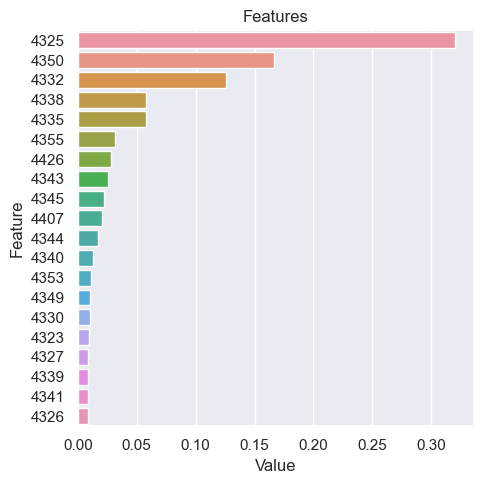

In [51]:
plot_importance(DecisionTreeClassifier().fit(X, y), X, 20)

**XGBoost Feature Importance**

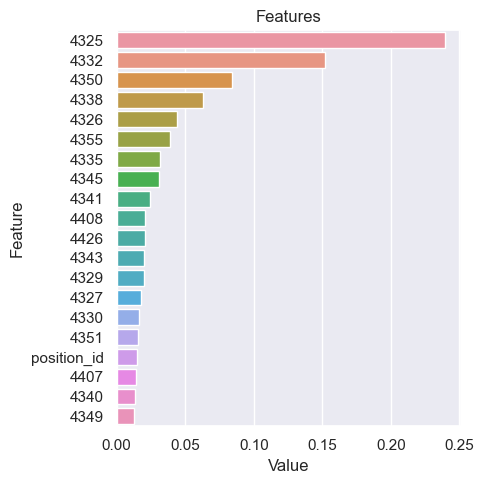

In [52]:
plot_importance(XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X, y), X, 20)

**Decision Tree Feature Importance**

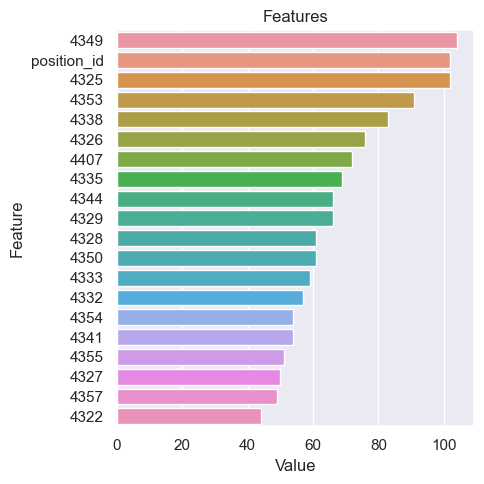

In [53]:
plot_importance(LGBMClassifier().fit(X, y), X, 20)